# **Lab 1 : Linear regression with NumPy**

In this exercise, you will implement a linear regressor for the house pricing problem. You will predict house prices training your predictor on previous collected data. 

The idea behind (multiple) linear regression is to extract a linear relation between features and target data which can be represented by the following equation:
\begin{equation}
y(x_1, x_2, \dots, x_n) = w_0 + w_1x_1 + w_2x_2+\dots + w_n x_n = w_0 + \sum_{i=1}^m w_i\cdot x_i.~~~~~~~~~~~~~~~~~~~(1)
\end{equation}

In [2]:
##################################################
# Imports
##################################################

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

# Settings
plt.style.use('seaborn-white')


##################################################
# Check function tool, skip this
##################################################

def check(func, print_log=False):

    # Set seed
    np.random.seed(1234)

    # Select function to check
    if func.__name__ == 'predict':
        args = {
            'x': np.random.normal(0, 1, size=(10, 501)),
            'w': np.random.normal(0, 1, size=(501, 1)),
        }
        res = 84.37925870442523
        res_ = func(**args).sum()
        cond = (res_.sum() - res) < 1e-8

    elif func.__name__ == 'compute_cost':
        args = {
            'x': np.random.normal(0, 1, size=(10, 501)),
            'y': np.random.normal(0, 1, size=(10, 1)),
            'w': np.random.normal(0, 1, size=(501, 1)),
        }
        res = 131.13466658728424
        res_ = func(**args)
        cond = (res_ - res) < 1e-8

    elif func.__name__ == 'compute_cost_multivariate':
        args = {
            'x': np.random.normal(0, 1, size=(10, 501)),
            'y': np.random.normal(0, 1, size=(10, 1)),
            'w': np.random.normal(0, 1, size=(501, 1)),
        }
        res = 131.13466658728424
        res_ = func(**args)
        cond = (res_ - res) < 1e-8

    elif func.__name__ == 'gradient_descent':
        args = {
            'x': np.random.normal(0, 1, size=(10, 501)),
            'y': np.random.normal(0, 1, size=(10, 1)),
            'w': np.random.normal(0, 1, size=(501, 1)),
            'learning_rate': 0.005,
            'num_iters': 10,
        }
        res = [
            158.544797156765, 
            2.203001889427611, 
            25.109538060963843,
        ] # Sums of the arryays
        res_ = func(**args)
        cond = all([(r_.sum() - r) < 1e-8 for r, r_ in zip(res, res_)])
    
    else:
        raise Exception(f'Error. The check of the function {func.__name__} is not implemented.')

    if cond:
        print(f'Your function "{func.__name__}" is correct!')
    else:
        print(f'Your function "{func.__name__}" is NOT correct!')

    # Print output log
    if print_log:
        if isinstance(res, list):
            for r, r_ in zip(res, res_):
                if isinstance(r_, np.ndarray):
                    r_ = r_.sum()
                print(f'Your output: {r_}, expected output: {r}')
        if isinstance(res, float) or isinstance(res, int) or isinstance(res, str):
            print(f'Your output: {res_}, expected output: {res}')

**Dataset description**

The Boston Housing dataset contains prices of various houses in Boston depending on several parameters. The dataset contains 506 samples and 13 features. Your task is to fit a linear model and predict prices using unseen data.

In [3]:
# Load dataset
dataset = load_boston()

# Print dataset info
print(dataset.data.shape)
print(dataset.keys())
print(dataset.feature_names)
print(dataset.DESCR)

(506, 13)
dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Bos

**Data analysis**

Before training a linear regressor, we will visualize the relationship between each feature and target data using histogram and scatter plots from the matplotlib library.
Let’s first plot the distribution of the target variable.

In [ ]:
# Retrieve input features and target prices
x = np.array(dataset.data) # Input data of shape [num_samples, num_feat]
y = np.array(dataset.target) # Targets of shape [num_samples]

# Info
print(f'Dataset shape -> {x.shape}, target variable shape -> {y.shape}')

Dataset shape -> (506, 13), target variable shape -> (506,)


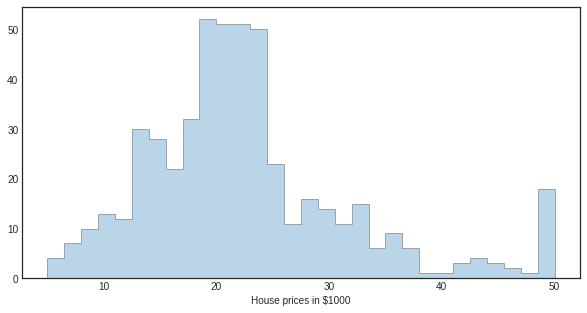

In [ ]:
# Price distribution
plt.figure(figsize=(10, 5))
kwargs = dict(histtype='stepfilled', alpha=0.3, density=False, bins=30, ec="k")
plt.hist(y, **kwargs)  
plt.xlabel("House prices in $1000")
plt.show()
plt.show()

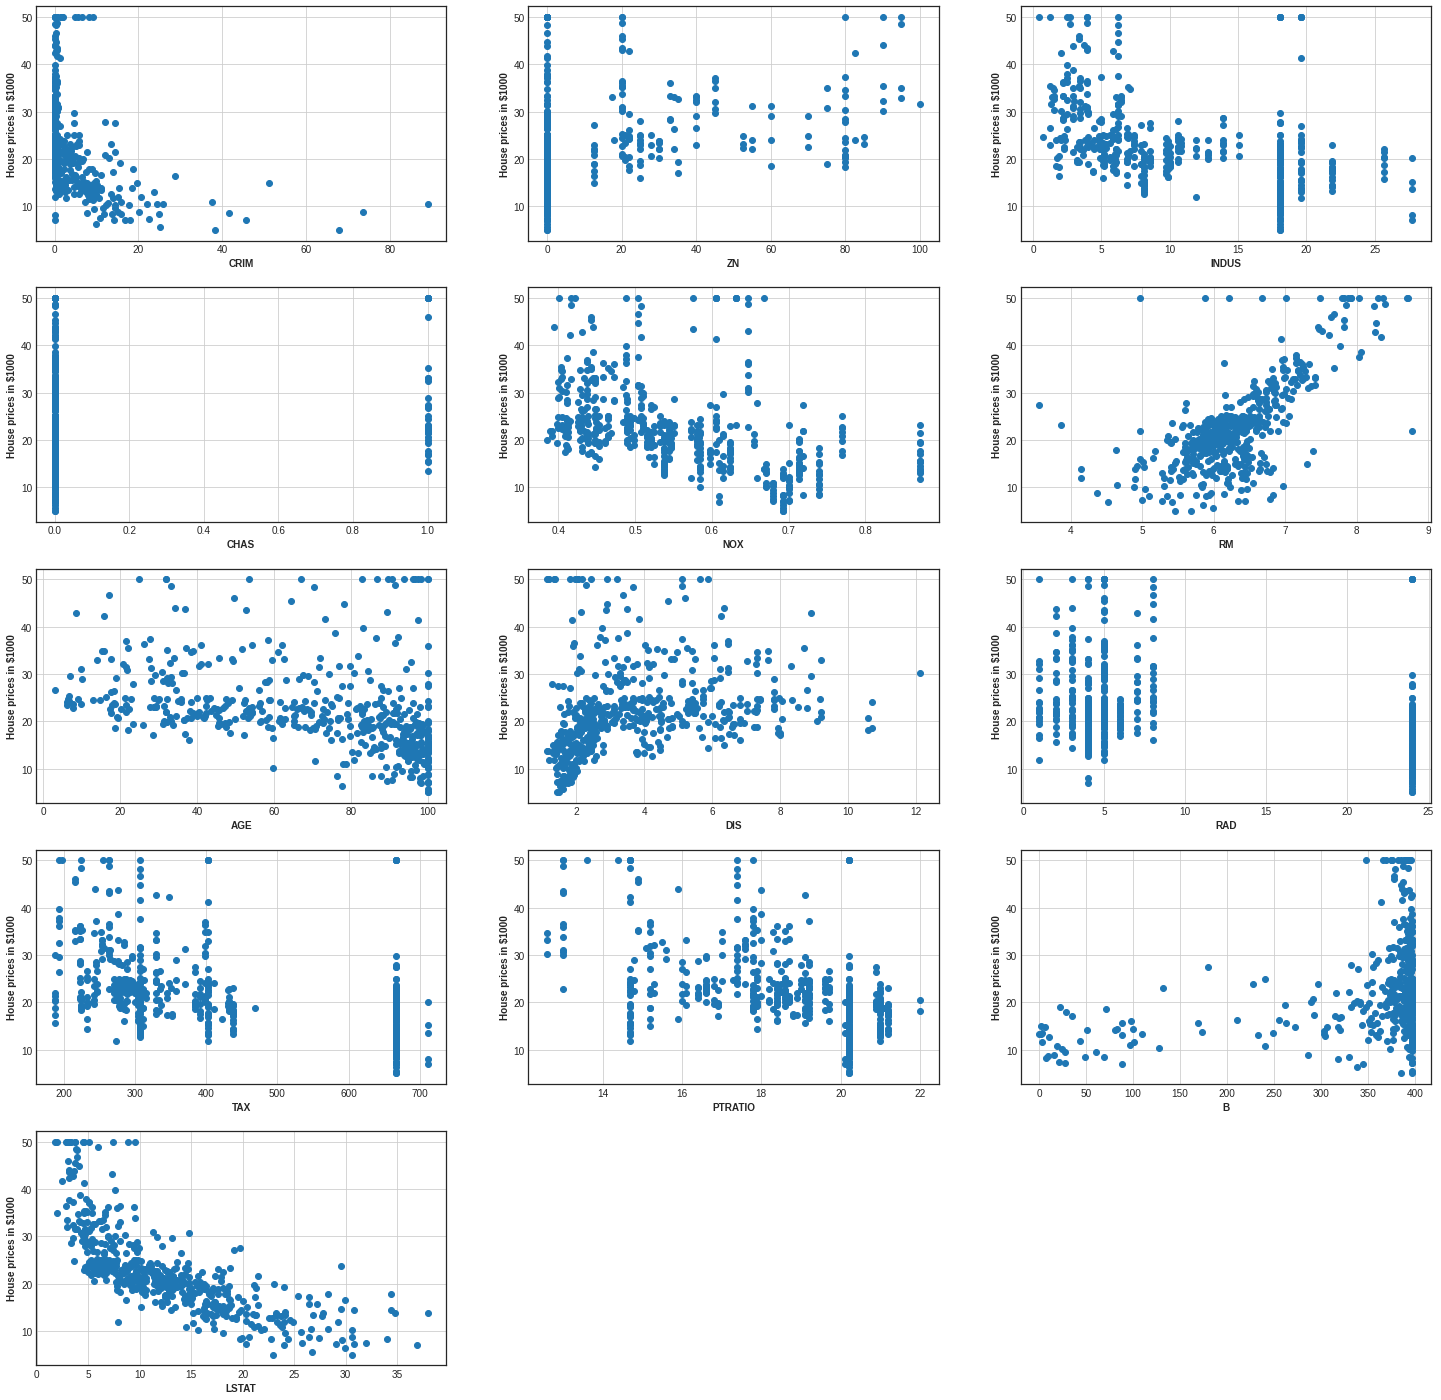

In [ ]:
# Plot (feature, target) plot, for each single feature
plt.figure(figsize=(25, 25))  
for idx_f, feat_name in enumerate(dataset.feature_names):
  plt.subplot(5, 3 , idx_f + 1)
  plt.scatter(x[:, idx_f], y, marker='o')
  plt.xlabel(feat_name, fontweight='bold')
  plt.ylabel('House prices in $1000', fontweight='bold')
  plt.grid(True)
plt.show()

**Simple linear regression**

In simple linear regression, a single independent variable is used to predict the value of a dependent variable. Since it is hard to *visualize* our model with multiple features, we will first predict the house prices with just one variable and then move to the regression with all the features.
For example, we can select the ‘LSTAT’ feature which shows a negative correlation with the house prices.

In [ ]:
# Select LSTAT feature from X
x_lstat = x[:, -1].reshape(-1,1)
y_price = y.reshape(-1,1)

# Print info
print(x_lstat.shape)
print(y_price.shape)

(506, 1)
(506, 1)


In [ ]:
# Split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_lstat, y_price, test_size=0.2, random_state=5)
num_tr = len(x_train)
num_feat = x_train.shape[-1]

# Append intercept term to x_train
print(x_train.shape)
x_train = np.concatenate([x_train, np.ones([num_tr, 1])], -1)
print(x_train.shape)
print(f'Total samples in X_train: {num_tr}')

(404, 1)
(404, 2)
Total samples in X_train: 404


The objective of linear regression is to minimize the cost function
\begin{equation}
J(w) = \frac{1}{2m}\sum_{i = 1}^{m} (h_w(x^{(i)})-y^{(i)})^2 ~~~~~~~~~~~~~~~~~~~(2)
\end{equation}
where the hypothesis $h_w(x)$ is given by the linear model 
\begin{equation}
h_w(x) = w^Tx = w_0+w_1x_1. ~~~~~~~~~~~~~~~~~~~~~~~~~~~~(3)
\end{equation}
In each iteration, we perform the following update:
\begin{equation}
w_j := w_j-\alpha\frac{1}{m}(h_w(x^{(i)})-y^{(i)})x_j^{(i)} ~~~~~~~~~~~~~~~~~~~(4)
\end{equation}

# Ex.1

Complete the following code to compute prediction as reported in Equation (3).

In [ ]:
##################################################
# Compute the prediction
##################################################

def predict(x, w):
    """
    Compute the prediction of a linear model.
    Inputs:
        x: np.ndarray input data of shape [num_samples, num_feat + 1]
        w: np.ndarray weights of shape [num_feat + 1, 1]
    Outputs:
        h: np.ndarray predictions of shape [num_samples, 1]
    """
    ##### WRITE YOUR CODE HERE #####
    
    ################################
    pass

# Test your code -> uncomment
#check(predict)

Your function "predict" is correct!


# Ex.2

Complete the following code to compute the cost function as reported in Equation (2).

In [ ]:
##################################################
# Loss function (mean squared error -> MSE)
##################################################

def compute_cost(x, y, w):
    """
    Inputs:
        x: np.ndarray input data of shape [num_samples, num_feat + 1]
        y: np.ndarray targets data of shape [num_samples, 1]
        w: np.ndarray weights of shape [num_feat + 1, 1]
    Outputs:
        mse: scalar.
    """

    ##### WRITE YOUR CODE HERE #####
    
    ################################
    pass

# Test your code -> uncomment
#check(compute_cost)

Your function "compute_cost" is correct!


# Gradient descent algorithm
Repeat until convergence (or maximum number of iterations) {
  1. Calculate gradient 
  2. Multiply by learning rate
  3. Subtract from weights

}

# Ex.3

Implement gradient descent algorithm as reported in Equation (4).

In [ ]:
def gradient_descent(x, y, w, learning_rate, num_iters):
    """
    Inputs:
        x: np.ndarray input data of shape [num_samples, num_feat + 1]
        y: np.ndarray targets data of shape [num_samples, 1]
        w: np.ndarray weights of shape [num_feat + 1, 1]
        learning_rate: scalar, the learning rate.
        num_iters: int, the number of iterations.
    Outputs:
        j_hist: list of loss values of shape [num_iters]
        w_opt: [num_feat + 1, 1]
        w_hist: [num_feat + 1, num_iters + 1]
    """
    ##### WRITE YOUR CODE HERE #####
    
    ################################
    pass

# Test your code -> uncomment
#check(gradient_descent)

Your function "gradient_descent" is correct!


Initial cost is:  299.38922029702974
Optimal parameters are: 
 [[-0.92205139]
 [33.92453385]]
Final cost is:  19.33735786848335


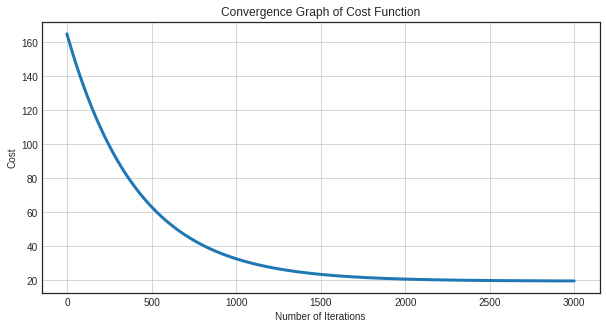

In [ ]:
# Initialize the parameters of the linear model
w = np.zeros([num_feat + 1, 1])

# Parameters for the gradient descent
num_iters = 3000
learning_rate = 0.005

# Compute the initial cost
initial_cost = compute_cost(x_train, y_train, w)
print("Initial cost is: ", initial_cost)

# Apply gradient descent algorithm
j_hist, w_opt, w_hist = gradient_descent(x_train, y_train, w, learning_rate, num_iters)
print("Optimal parameters are: \n", w_opt)
print("Final cost is: ", j_hist[-1])

# Plot loss history
plt.figure(figsize=(10, 5))  
plt.plot(range(len(j_hist)), j_hist, lw=3)
plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.grid()
plt.show()


Plotting the model fitted line on the output variable.


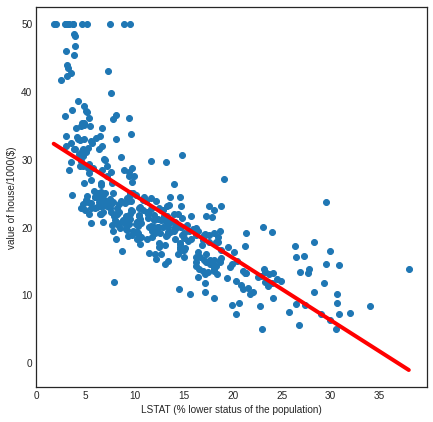

In [ ]:
# Plot the model fitted line on the output variable
plt.figure(figsize=(7, 7))  
prediction_space = np.linspace(x_lstat.min(), x_lstat.max()).reshape(-1,1) 
prediction_space = np.concatenate([prediction_space, np.ones([len(prediction_space), 1])], -1)
plt.scatter(x_train[:, 0], y_train)
plt.plot(
    prediction_space[:, 0], 
    predict(
        prediction_space, 
        w_opt
    ), 
    color='r', linewidth=4
)
plt.ylabel('value of house/1000($)')
plt.xlabel('LSTAT (% lower status of the population)')
plt.show()

# Visualizing $J(w)$ (Optional)

To better understand the cost function, you can plot the cost over a 2-dimensional grid of $w_0$ and $w_1$ values.

Text(0.5, 0.92, 'J(w0, w1)')

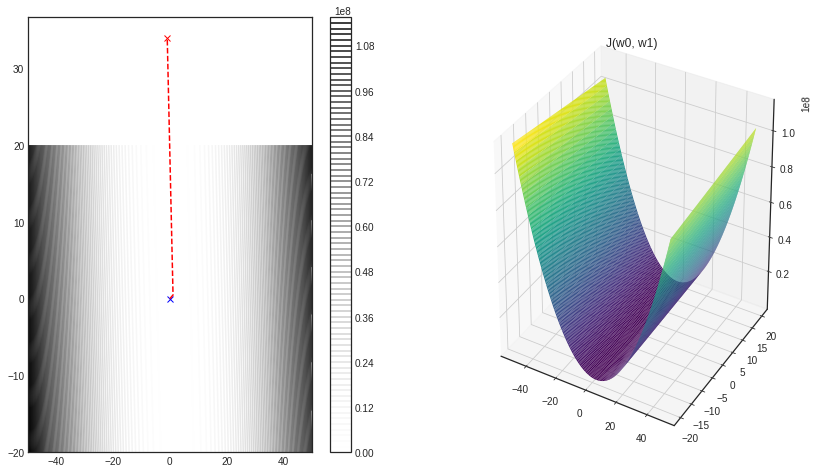

In [ ]:
fig = plt.figure(figsize=(14,8)) # create the canvas for plotting
ax1 = fig.add_subplot(1,2,1)

# Create grid of w0/w1 values
w0_values = np.linspace(-50, 50, 100);
w1_values = np.linspace(-20, 20, 100);
W0, W1 = np.meshgrid(w0_values, w1_values)
J = np.zeros((w0_values.shape[0] * w1_values.shape[0]))

# Compute cost function for each point in the grid
for i, (w0,w1) in enumerate(zip(np.ravel(W0), np.ravel(W1))):
  w = [w0, w1]
  J[i] = compute_cost(x_train, y_train, w)

J = J.reshape(w0_values.shape[0], w1_values.shape[0])

# Plot cost function
plt.contour(W0, W1, J, 100)
plt.colorbar()

# Plot params history
plt.plot(w_hist[0, 0], w_hist[1, 0], 'bx', # Initial position
         w_hist[0, -1], w_hist[1, -1], 'rx', # Final position
         w_hist[0, ::10], w_hist[1, ::10], 'r--')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(W0, W1, J, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax2.set_title('J(w0, w1)')

# **Multiple Linear Regression**
We will now consider all the features of our dataset. Nevertheless, some features may differ by orders of magnitude. For this reason, we firstly perform feature scaling since it can make gradient descent converge much more quickly.

We will consider a normalization technique called Standardization which is based on mean and standard deviation of X as follows:
\begin{equation}
z = \frac{x - \mu}{\sigma}~~~~~~~~~~~~~~~~~~~(5)
\end{equation}
where
\begin{equation}
\mu = \frac{1}{m}\sum_{i=1}^m x_i,~~~\sigma = \sqrt{\frac{1}{m}\sum_{i=1}^m (x_i-\mu)^2}. ~~~~~~~~~~~~~~~~~~~(6)
\end{equation}

In [ ]:
# Split the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
num_tr = len(x_train)
num_feat = x_train.shape[-1]

# Normalize the data
mu = x_train.mean(axis=0) # Mean from the train set
sigma = x_train.std(axis=0) # STD from the train set
x_train = (x_train - mu) / sigma
x_test = (x_test - mu) / sigma # Normalize with stats from the train
y_train = y_train.reshape(-1, 1)

# Add intercept term
x_train = np.concatenate([x_train, np.ones([num_tr, 1])], -1)
x_test = np.concatenate([x_test, np.ones([len(x_test), 1])], -1)
print(x_train.shape)

(404, 14)


**Implementation detail**: For the multivariate case, we can consider the vectorized form of the cost function:
\begin{equation}
J(w) = \frac{1}{2m}(Xw-y)^T(Xw-y) ~~~~~~~~~~~~~~~~~~~(7)
\end{equation}

# Ex.4
Implement the cost function for the multivariate case as reported in Equation (7).

In [ ]:
##################################################
# Loss function (mean squared error -> MSE)
##################################################

def compute_cost_multivariate(x, y, w):
    """
    Inputs:
        x: np.ndarray input data of shape [num_samples, num_feat + 1]
        y: np.ndarray targets data of shape [num_samples, 1]
        w: np.ndarray weights of shape [num_feat + 1, 1]
    Outputs:
        mse: scalar.
    """

    ##### WRITE YOUR CODE HERE #####
    
    ################################
    pass

# Test your code -> uncomment
#check(compute_cost_multivariate, print_log=True)

Your function "compute_cost_multivariate" is correct!
Your output: 131.1346665872843, expected output: 131.13466658728424


Initial cost is:  303.27769801980196 

Optimal parameters are: 
 [[-0.99613196]
 [ 0.6821875 ]
 [ 0.25122685]
 [ 0.72290496]
 [-2.0188908 ]
 [ 3.15178459]
 [-0.17847401]
 [-3.07811745]
 [ 2.17070847]
 [-1.67711365]
 [-2.0352437 ]
 [ 1.12909445]
 [-3.60776628]
 [22.79653465]] 

Final cost is:  10.821204083484256


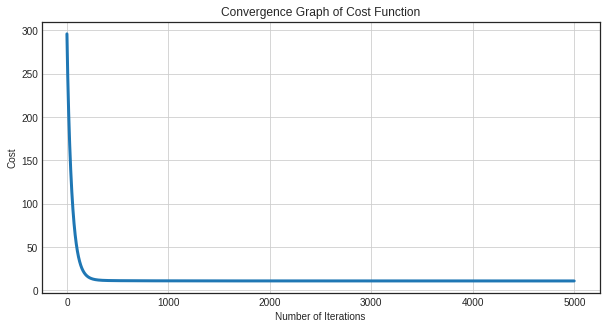

In [ ]:
# Initialize the weights of the linear model
w = np.zeros((num_feat + 1, 1))

# Parameters of the gradient descent
num_iters = 5000
learning_rate = 0.01

# Comput the initial cost
initial_cost = compute_cost_multivariate(x_train, y_train, w)
print("Initial cost is: ", initial_cost, "\n")

# Gradient descent
(j_hist, w_opt, _) = gradient_descent(x_train, y_train, w, learning_rate, num_iters)

# Output info
print("Optimal parameters are: \n", w_opt, "\n")
print("Final cost is: ", j_hist[-1])
plt.figure(figsize=(10, 5))  
plt.plot(range(len(j_hist)), j_hist, lw=3)
plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.grid()
plt.show()

In [ ]:
# Predicted prices
y_test_pred = predict(x_test, w_opt)

Text(0.5, 1.0, 'Actual Prices vs Predicted prices')

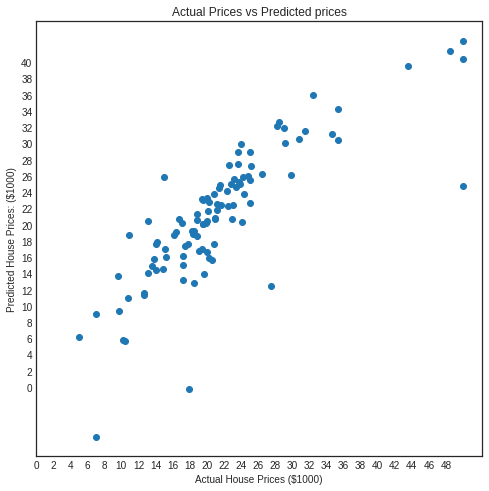

In [ ]:
plt.figure(figsize=(8, 8))  
plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual House Prices ($1000)")
plt.ylabel("Predicted House Prices: ($1000)")
plt.xticks(range(0, int(max(y_test)), 2))
plt.yticks(range(0, int(max(y_test_pred)), 2))
plt.title("Actual Prices vs Predicted prices")

# **Performance evaluation**

To evaluate the performance of our linear model, we define the following score:

\begin{equation}
Score = 1 - \frac{\sum_{i=1}^q (y^{(i)}-\hat{y}^{(i)})^2}{\sum_{i=1}^q (y^{(i)}-\overline{y}^{(i)})^2} ~~~~~~~~~~~~~~~~~~~(8)
\end{equation}

We also compare our model to the *Scikit-learn* linear regressor.

In [ ]:
def score(y, y_pred):
    score = 1 - (((y - y_pred) ** 2).sum() / ((y - y.mean()) ** 2).sum())
    return score

In [ ]:
# Sklearn linear regressor
from sklearn.linear_model import LinearRegression

sklearn_regressor = LinearRegression().fit(x_train, y_train)
sklearn_train_accuracy = sklearn_regressor.score(x_train, y_train)
sklearn_test_accuracy = sklearn_regressor.score(x_test, y_test)

# Prediction for training set
y_train_pred = predict(x_train, w_opt)
train_accuracy = score(y_train, y_train_pred)
test_accuracy = score(y_test[:, np.newaxis], y_test_pred)
print("Training accuracy   Our model -> %f\tSklearn's implementation -> %f" % (train_accuracy, sklearn_train_accuracy))
print("Test accuracy       Our model -> %f\tSklearn's implementation -> %f" % (test_accuracy, sklearn_test_accuracy))

Training accuracy   Our model -> 0.750874	Sklearn's implementation -> 0.750886
Test accuracy       Our model -> 0.668113	Sklearn's implementation -> 0.668759


# Additional 1
Try out different learning rates to converge quickly. Choose different values of the learning rate on a log-scale.

# Additional 2

Linear regression problems can also be solved (in one step) in closed-form using the following formula:

$w = (X^T X)^{-1}X^Ty$.

Such formula does not require any feature scaling.